In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn.metrics import mean_absolute_error

In [46]:
btc = yf.download('BTC-USD', start='2020-01-01', end='2024-01-01')['Close']
print(btc)
returns = np.log(btc / btc.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed

Ticker           BTC-USD
Date                    
2020-01-01   7200.174316
2020-01-02   6985.470215
2020-01-03   7344.884277
2020-01-04   7410.656738
2020-01-05   7411.317383
...                  ...
2023-12-27  43442.855469
2023-12-28  42627.855469
2023-12-29  42099.402344
2023-12-30  42156.902344
2023-12-31  42265.187500

[1461 rows x 1 columns]


In [4]:
returns = returns.asfreq('D')

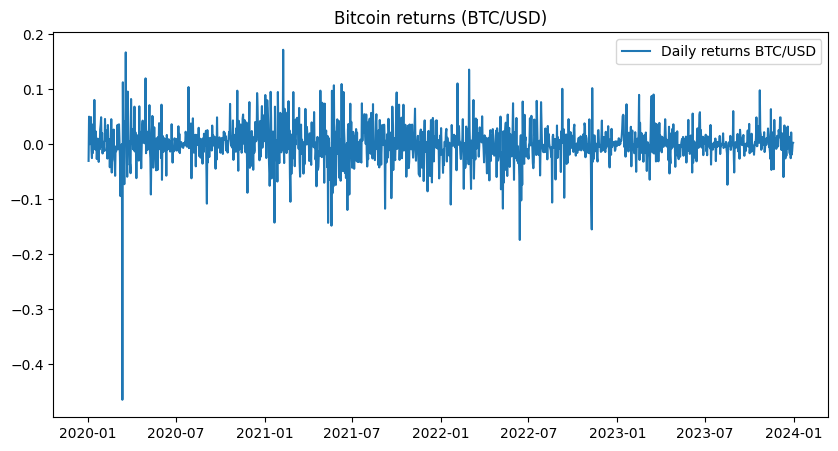

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(returns, label="Daily returns BTC/USD")
plt.title("Bitcoin returns (BTC/USD)")
plt.legend()
plt.show()

In [6]:
train_size = int(len(returns) * 0.75)  # 75% of data for training
train, test = returns[:train_size], returns[train_size:]

In [7]:
#stationarity test ADF
adf_test = adfuller(train)

print("ADF test result :")
print(f"ADF statistic : {adf_test[0]}")
print(f"p-valeur : {adf_test[1]}")
print("Critical values :", adf_test[4])

ADF test result :
ADF statistic : -10.669771471335416
p-valeur : 4.1962973456480166e-19
Critical values : {'1%': -3.4363857496063455, '5%': -2.8642050392821794, '10%': -2.5681889563132314}


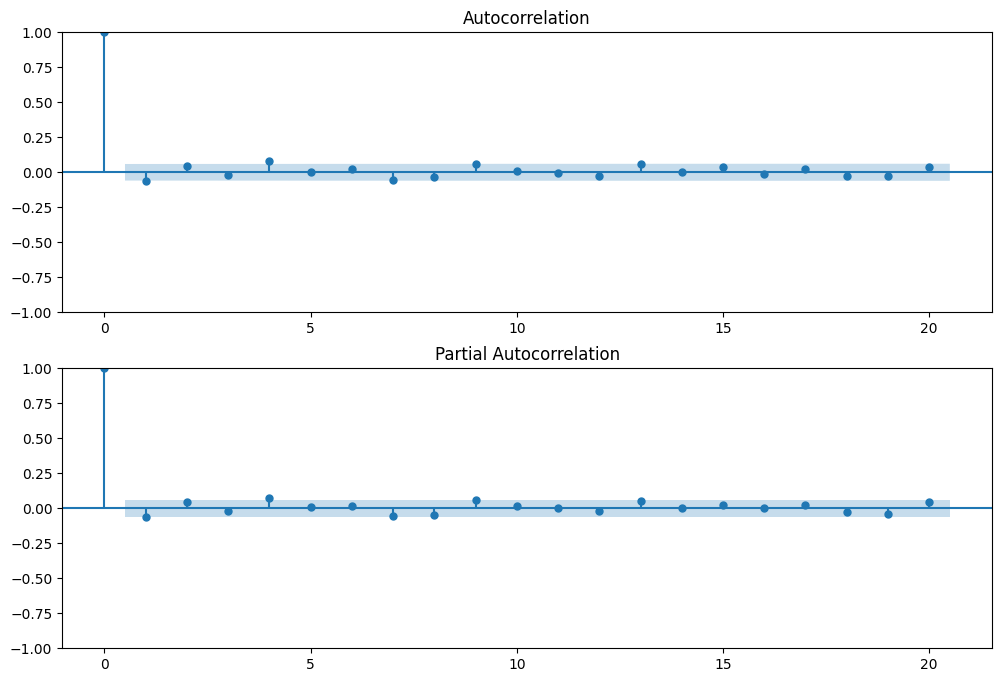

In [8]:
# plot ACF and  PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train, ax=ax[0], lags=20)
plot_pacf(train, ax=ax[1], lags=20)
plt.show()

In [10]:
p_range = range(0, 4)
q_range = range(0, 4)
best_aic = float('inf')
best_order = None
best_model = None

# Test all combinations of p and q
for p, q in itertools.product(p_range, q_range):
    try:
        model = ARIMA(train, order=(p, 0, q))  # d=0 car ARMA
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = (p, q)
            best_model = result
    except:
        continue

print(f"Best ARMA model: {best_order} with AIC = {best_aic}")

c:\Users\antoi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\antoi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\antoi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\antoi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati

Best ARMA model: (1, 1) with AIC = -4009.337674512237


In [22]:
best_model = ARIMA(train, order=(1, 0, 1))
best_result = best_model.fit()

print(best_result.summary())
print(best_result.params)

                               SARIMAX Results                                
Dep. Variable:                BTC-USD   No. Observations:                 1095
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2008.669
Date:                Sun, 30 Mar 2025   AIC                          -4009.338
Time:                        12:27:26   BIC                          -3989.344
Sample:                    01-02-2020   HQIC                         -4001.772
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.620      0.535      -0.002       0.003
ar.L1         -0.7364      0.134     -5.492      0.000      -0.999      -0.474
ma.L1          0.6746      0.147      4.602      0.0

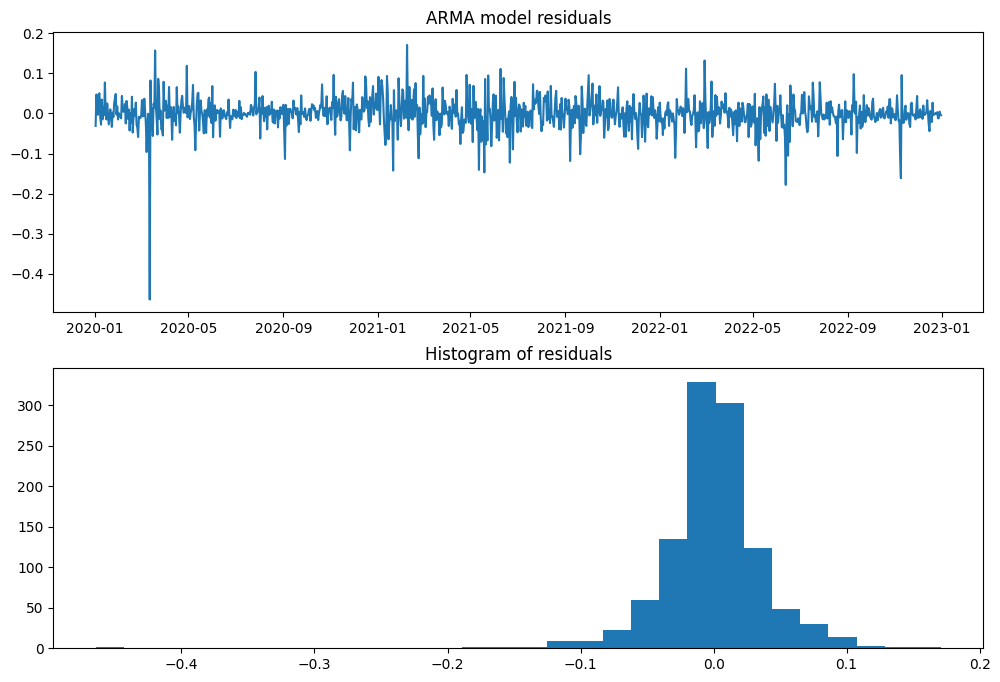

In [23]:
residuals = best_result.resid

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(residuals)
ax[0].set_title('ARMA model residuals')
ax[1].hist(residuals, bins=30)
ax[1].set_title('Histogram of residuals')
plt.show()


In [24]:
print(returns.columns)

Index(['BTC-USD', 'Fitted'], dtype='object', name='Ticker')


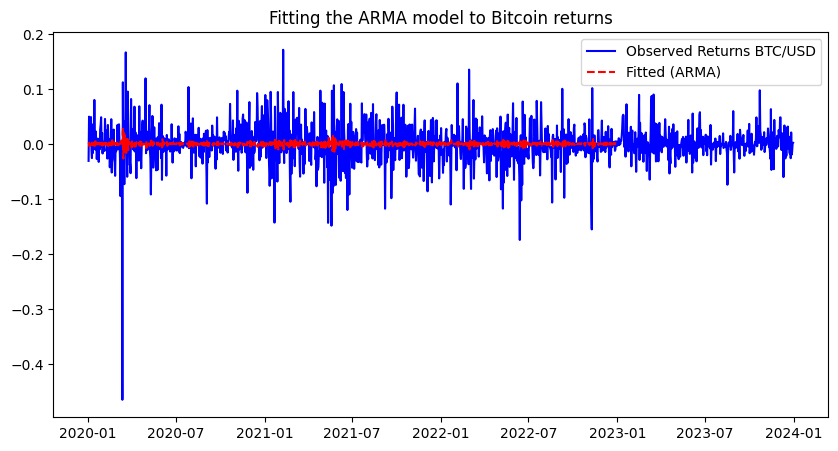

In [25]:
returns['Fitted'] = best_result.fittedvalues

plt.figure(figsize=(10, 5))
plt.plot(returns.index, returns['BTC-USD'], label="Observed Returns BTC/USD", color="blue")
plt.plot(returns.index, returns['Fitted'], label="Fitted (ARMA)", linestyle='dashed', color="red")
plt.title("Fitting the ARMA model to Bitcoin returns")
plt.legend()
plt.show()

In [41]:
predictions = best_result.forecast(steps=len(test))
print(predictions)
mae = mean_absolute_error(test, predictions)
print(f"Error MAE : {mae:.6f}")

mae_percentage = (mae / test['BTC-USD'].abs().mean()) * 100
print(f"Error MAE Percentage : {mae_percentage:.2f}%")

2023-01-01    0.000797
2023-01-02    0.000727
2023-01-03    0.000778
2023-01-04    0.000741
2023-01-05    0.000768
                ...   
2023-12-27    0.000757
2023-12-28    0.000757
2023-12-29    0.000757
2023-12-30    0.000757
2023-12-31    0.000757
Freq: D, Name: predicted_mean, Length: 365, dtype: float64
Error MAE : 0.015271
Error MAE Percentage : 100.10%


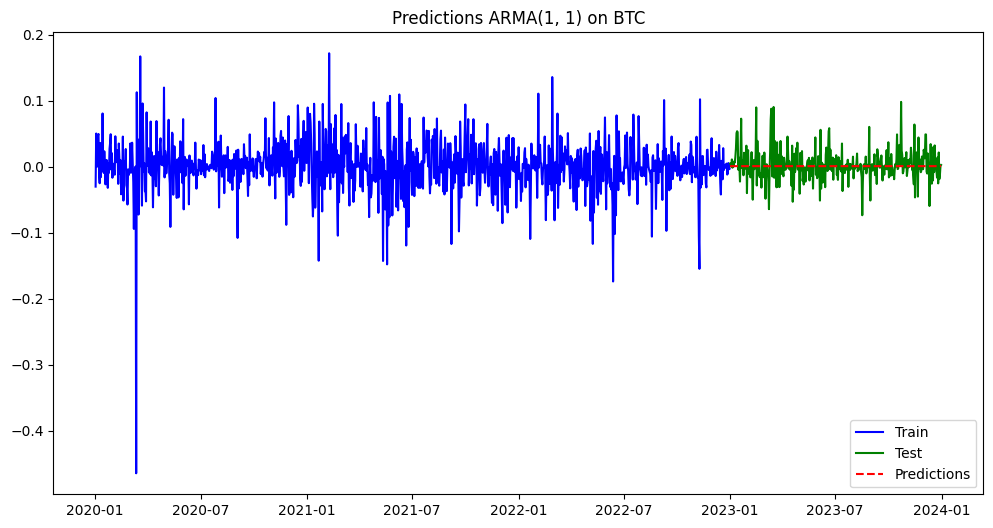

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test", color="green")
plt.plot(test.index, predictions, label="Predictions", color="red", linestyle="dashed")
plt.legend()
plt.title(f"Predictions ARMA{best_order} on BTC")
plt.show()

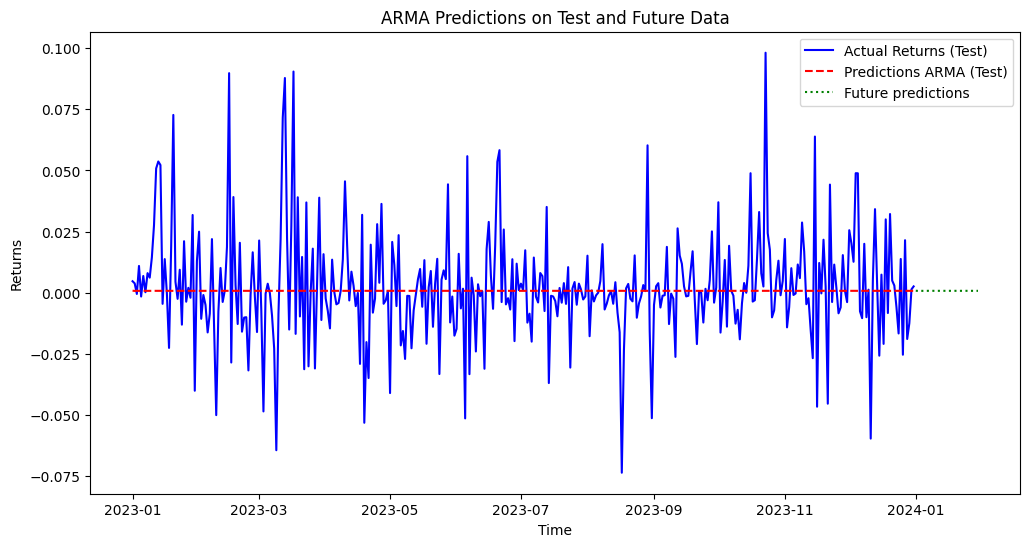

In [28]:
horizon = 30

future_predictions = best_result.forecast(steps=horizon)

future_index = pd.date_range(start=test.index[-1], periods=horizon+1, freq='D')[1:]

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Returns (Test)", color="blue")
plt.plot(test.index, predictions, label="Predictions ARMA (Test)", color="red", linestyle="dashed")
plt.plot(future_index, future_predictions, label="Future predictions", color="green", linestyle="dotted")
plt.title("ARMA Predictions on Test and Future Data")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend()
plt.show()


In [ ]:
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test", color="green")
plt.plot(test.index, predictions, label="Predictions", color="red", linestyle="dashed")

In [45]:
print(train)

Ticker       BTC-USD
Date                
2020-01-02 -0.030273
2020-01-03  0.050172
2020-01-04  0.008915
2020-01-05  0.000089
2020-01-06  0.047161
...              ...
2022-12-27 -0.012048
2022-12-28 -0.009895
2022-12-29  0.005409
2022-12-30 -0.002392
2022-12-31 -0.003324

[1095 rows x 1 columns]


2023-01-01    16560.681848
2023-01-02    16572.733494
2023-01-03    16585.637423
2023-01-04    16597.929741
2023-01-05    16610.689301
                  ...     
2023-12-27    21746.331266
2023-12-28    21762.794068
2023-12-29    21779.269332
2023-12-30    21795.757069
2023-12-31    21812.257288
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


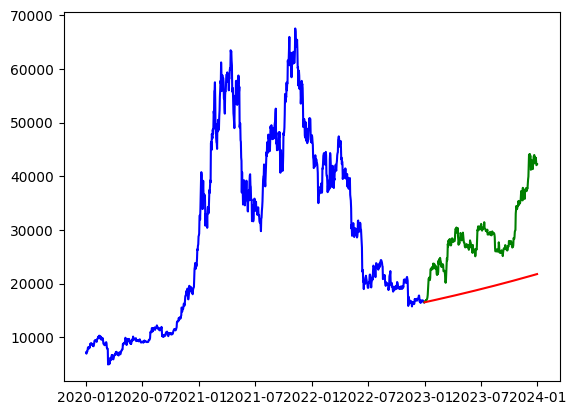

In [60]:
predicted_returns_cumsum = np.cumsum(predictions)
predicted_prices = btc.iloc[train_size]['BTC-USD'] * np.exp(predicted_returns_cumsum)
print(predicted_prices)
plt.plot(btc[:train_size].index, btc[:train_size]['BTC-USD'], label='Train', color='blue')
plt.plot(btc[train_size:].index, btc[train_size:]['BTC-USD'], label='Test', color='green')
plt.plot(btc[train_size+1:].index, predicted_prices, label='Predictions', color='red')


